In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous
print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(38598, 25)
(38598, 3)


In [6]:
X_motion_CoM_continuous[0]

array([0.1, 0.0, 0.0, 0.028489577089618634, -0.029145302018442662,
       0.022371074929438357, -0.0008381898040188694, 0.0231294258002537,
       0.009549917970638715, 0.22305503249962916, 0.17312669533899627,
       -0.4095482720203519, 0.23991911170027655, -0.1660954835575981,
       -0.4097740078763965, -0.23724878115057912, 0.16637246153782909,
       -0.4126119486139448, -0.25387675804380694, -0.1600415552684769,
       -0.41301528981091734, True, False, False, True], dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.006780646577309566, 0.0017755153220013614, 0.0020288801331269663],
      dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_continuous[:, 22] == 1)[0]
X_motion_CoM_continuous_FR_RL = X_motion_CoM_continuous[idx_fr_rl_swinging]
Y_motion_CoM_continuous_FR_RL = Y_motion_CoM_continuous[idx_fr_rl_swinging]
print(X_motion_CoM_continuous_FR_RL.shape)
print(Y_motion_CoM_continuous_FR_RL.shape)

(19325, 25)
(19325, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_continuous_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.017155230354610657, 0.026804817797485003,
       0.05156132573315406, -0.00914701948280022, 0.03151450124291852,
       -0.022585254245860303, 0.23698766733875087, 0.17026876271190863,
       -0.4087347094129614, 0.23344301406436113, -0.16811551980568334,
       -0.40935064505495683, -0.24342877859028744, 0.16518854498804314,
       -0.4124342944605045, -0.24083982033724247, -0.16411242023259198,
       -0.412438719130193, False, True, True, False], dtype=object)

In [11]:
Y_motion_CoM_continuous_FR_RL[0, :]

array([0.01106356308303996, -0.00451816069495816, -0.0016065134820395315],
      dtype=object)

### Linear Regression

In [38]:
# Input
X = np.hstack((X_motion_CoM_continuous_FR_RL[:, :3], # motion command
               X_motion_CoM_continuous_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 18:20])) # RR (x,y) position
               
# Labels
Y = np.array([Y_motion_CoM_continuous_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9934256320058997
RMSE:  0.003121965367564855
The lowest error is:  4.2957812432242726e-07
The highest error is:  0.05410955428350406
The avg. error is:  0.0017195223767215043


In [39]:
model_fr_com_x.coef_

array([[ 0.21674366, -0.03172167, -0.02416405, -0.15187736,  0.13316871,
         0.25660025, -0.01237345, -0.01050544,  0.05378222, -0.32570118,
         0.22634539]])

In [40]:
model_fr_com_x.intercept_

array([-0.11286262])

Text(0, 0.5, 'Predictions')

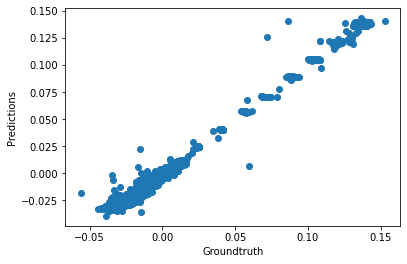

In [41]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [42]:
#%store model_fr_com_x

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [86]:
# Input
X = np.hstack((X_motion_CoM_continuous_FR_RL[:, :3], # motion command
               X_motion_CoM_continuous_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 18:20])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_continuous_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9972327617051365
RMSE:  0.00416526611359207
The lowest error is:  2.4275440102528023e-08
The highest error is:  0.05765490306026623
The avg. error is:  0.002535811716637426


In [87]:
model_fr_com_y.coef_

array([[-0.01063686,  0.20068636,  0.19874541,  0.05406989, -0.34364412,
         0.11186589,  0.04677536,  0.03605651,  0.13799564,  0.13780997,
        -0.07374109]])

In [88]:
model_fr_com_y.intercept_

array([0.03068899])

Text(0, 0.5, 'Predictions')

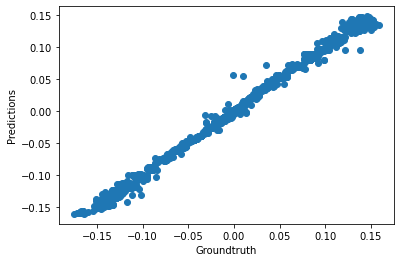

In [89]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [27]:
#%store model_fr_com_y

In [28]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")